<a href="https://colab.research.google.com/github/lorenzopaolucci/prova/blob/master/dbscan_finale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Generazione griglia controllo con spot di 1000, 3000, 10000, 30000 fotoni**

In [0]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.cluster import DBSCAN
from sklearn import metrics
from scipy.stats import norm
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

L = 50                        # Dimensione griglia
centers = [[L*0.5-1,L*0.5-1]] # Centro del blob
sigma_noise = 2               # Sigma del rumore
sigma_spatial = 4             # Sigma della distribuzione spaziale del blob (in pixel)

min_eps = 4
max_eps = 8
step_eps = 0.5

th = 1.5*sigma_noise
range_grid = [1000, 3000, 10000, 30000]

def array_for_fit(array):
  result = []
  value = 0
  for i in array:
    value += 1
    for j in range(0, int(i), 1):
      result.append(value)
  return result
  

# Genero le griglie

grid = np.zeros((L,L))        # Contiene le "coordinate" di ogni pixel, e il valore del segnale
background = np.zeros((L,L))  # Griglia background

# Genero il fondo

background_list = []
noise_list = []

for i in np.arange(0,L,1):    

  for j in np.arange(0,L,1):

    r = np.random.normal(0,2)
    background[i][j] = r
    noise_list.append(r)

    if background[i][j] != 0:
      background_list.append([j,i,background[i][j]])


background_plot = np.array(background_list)

# Istogramma rumore 

fig = plt.figure(figsize=(30,20))
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

hist_x = np.apply_along_axis(sum,0,background)
hist_y = np.apply_along_axis(sum,1,background)
x = np.linspace(0,L,L)
x_gaus = np.linspace(-6, 6, L)
hist_x_fit = array_for_fit(hist_x)
hist_y_fit = array_for_fit(hist_y)

ax1 = plt.subplot2grid((2,6),(1,0),rowspan=2,colspan=2)
ax1.scatter(background_plot[:,0],background_plot[:,1],c=background_plot[:,2],cmap='jet')

#ax2 = plt.subplot2grid((3,6),(1,2),colspan=1,rowspan=2,sharey=ax4)
#ax2.hist(hist_y_fit, bins=10, color='dodgerblue', label='Marginalizzazione su asse y', orientation='horizontal')
#ax2.legend( loc='upper left', borderpad=1)

#ax3 = plt.subplot2grid((3,6),(0,0),colspan=2,rowspan=1,sharex=ax4)
#ax3.hist(hist_x_fit, bins=10, color='dodgerblue', label='Marginalizzazione su asse x')
#ax3.legend( loc='upper left', borderpad=1)
plt.title('Griglia del rumore', fontsize = 18)

mu, std = norm.fit(noise_list)
ax4 = plt.subplot2grid((2,6),(1, 4),colspan=2,rowspan=2)
ax4.hist(noise_list, bins=10, color='dodgerblue', label='Istogramma fotoni di rumore $\mu_{exp}$= 0, $\sigma_{exp}$= %.1lf'%sigma_noise, density=True)
ax4.plot(x_gaus, np.exp(-0.5*((x_gaus-mu)/std)**2) /(std*np.sqrt(2*np.pi)), 'r--', linewidth=3, label='Fit gaussiano $\mu$= %.2lf, $\sigma$= %.2lf'%(mu, std))
ax4.legend( loc='upper left', borderpad=1, fontsize=12)
plt.title('Distribuzione dei fotoni di rumore prima di applicare la soglia (rinormalizzato)', fontsize = 18)
plt.ylim(0, 0.25)

plt.show()

#Genero il segnale

for n_samples in range_grid:
  
  signal = np.zeros((L,L))      # Griglia segnale
  X, blob_labels = make_blobs(n_samples=n_samples, centers=centers, cluster_std=sigma_spatial, random_state=0)

  for j in np.arange(0,len(X),1):

    x = int(np.round(X[j][0]))
    y = int(np.round(X[j][1]))

    signal[x][y] += 1

  signal_list = []
 
  for i in np.arange(0,L,1):

    for j in np.arange(0,L,1):

      if signal[i][j] != 0:
        signal_list.append([j,i,signal[i][j]])
  
  
  signal_plot = np.array(signal_list)


  # Istogramma segnale

  print('Istogramma con %d fotoni di segnale:'%n_samples)
  hist_x = np.apply_along_axis(sum,0,signal)
  hist_y = np.apply_along_axis(sum,1,signal)
  x = np.linspace(0,L,L)

  fig = plt.figure(figsize=(15,15))
  fig.subplots_adjust(hspace=0)
  fig.subplots_adjust(wspace=0)

  ax1 = plt.subplot2grid((3,3),(1,0),rowspan=2,colspan=2)
  ax1.scatter(signal_plot[:,0],signal_plot[:,1],c=signal_plot[:,2],cmap='jet')

  ax2 = plt.subplot2grid((3,3),(1,2),colspan=1,rowspan=2,sharey=ax1)
  hist_y_fit = array_for_fit(hist_y)
  mu, std = norm.fit(hist_y_fit)
  ax2.hist(hist_y_fit, bins=10, density=True, color='dodgerblue', orientation='horizontal', label='Marginalizzazione asse y')
  ax2.plot(np.exp(-0.5*((x-mu)/std)**2) /(std*np.sqrt(2*np.pi)), x, 'r--', linewidth=3, label='Gaussiana $\mu$= %.2lf, $\sigma$= %.2lf'%(mu, std))
  print('Valori della marginalizzazione lungo l asse y:')
  print('attesi:  \t\u03BC= %.2lf\t\u03C3= %.2lf'%(centers[0][1], sigma_spatial))
  print('misurati:\t\u03BC= %.2lf\t\u03C3= %.2lf\n'%(mu, std))
  ax2.legend( loc='upper left', borderpad=1)
 
  ax3 = plt.subplot2grid((3,3),(0,0),colspan=2,rowspan=1,sharex=ax1)
  hist_x_fit = array_for_fit(hist_x)
  mu, std = norm.fit(hist_x_fit)
  ax3.hist(hist_x_fit, bins=10, density=True, color='dodgerblue', label='Marginalizzazione asse x')
  ax3.plot(x, np.exp(-0.5*((x-mu)/std)**2) /(std*np.sqrt(2*np.pi)), 'r--', linewidth=3, label='Gaussiana $\mu$= %.2lf, $\sigma$= %.2lf'%(mu, std))
  ax3.legend( loc='upper left', borderpad=1)
  plt.title('Griglia del segnale con %d fotoni'%n_samples, fontsize = 18)
  print('Valori della marginalizzazione lungo l asse x:')
  print('attesi:  \t\u03BC= %.2lf\t\u03C3= %.2lf'%(centers[0][0],sigma_spatial))
  print('misurati:\t\u03BC= %.2lf\t\u03C3= %.2lf\n'%(mu, std))
  plt.show()
  print('\n\n\n\n')

**GENERAZIONE GRIGLIA**


In [0]:
n_samples =3000               # Numero di segnali generati

# Genero le griglie

grid = np.zeros((L,L))        # Contiene le "coordinate" di ogni pixel, e il valore del segnale
background = np.zeros((L,L))  # Griglia background
signal = np.zeros((L,L))      # Griglia segnale

# Genero il fondo

for i in np.arange(0,L,1):    

  for j in np.arange(0,L,1):

    r = np.random.normal(0,2)
    background[i][j] = r

# Genero il blob

X, blob_labels = make_blobs(n_samples=n_samples, centers=centers, cluster_std=sigma_spatial, random_state=0)

# Discretizzazione del blob

for j in np.arange(0,len(X),1):

  x = int(np.round(X[j][0]))
  y = int(np.round(X[j][1]))

  signal[x][y] += 1

# Somma background+segnale

count=0
tot_noise = 0

for j in np.arange(0,L,1):

  for i in np.arange(0,L,1):

    s = signal[i][j] + background[i][j]

    if s >= th:

      grid[i][j] = np.round(s)
      count += 1

    if signal[i][j] == 0 and background[i][j] >= th:

      background[i][j] = np.round(background[i][j])
      tot_noise += 1

    else:

      background[i][j] = 0

    if s >= th and signal[i][j] != 0:

      signal[i][j] = np.round(s)

    else:

      signal[i][j] = 0

tot_signal = count - tot_noise

# Creazione array coordinate per DBSCAN

points_list = []
signal_list = []
background_list= []
 
for i in np.arange(0,L,1):

  for j in np.arange(0,L,1):

    if grid[i][j] != 0:

      points_list.append([j,i,grid[i][j]])

    if signal[i][j] != 0:
      signal_list.append([j,i,signal[i][j]])

    if background[i][j] != 0:
      background_list.append([j,i,background[i][j]])

points = np.array(points_list)
signal_plot = np.array(signal_list)
background_plot = np.array(background_list)

**PLOT GRIGLIA E ISTOGRAMMI**

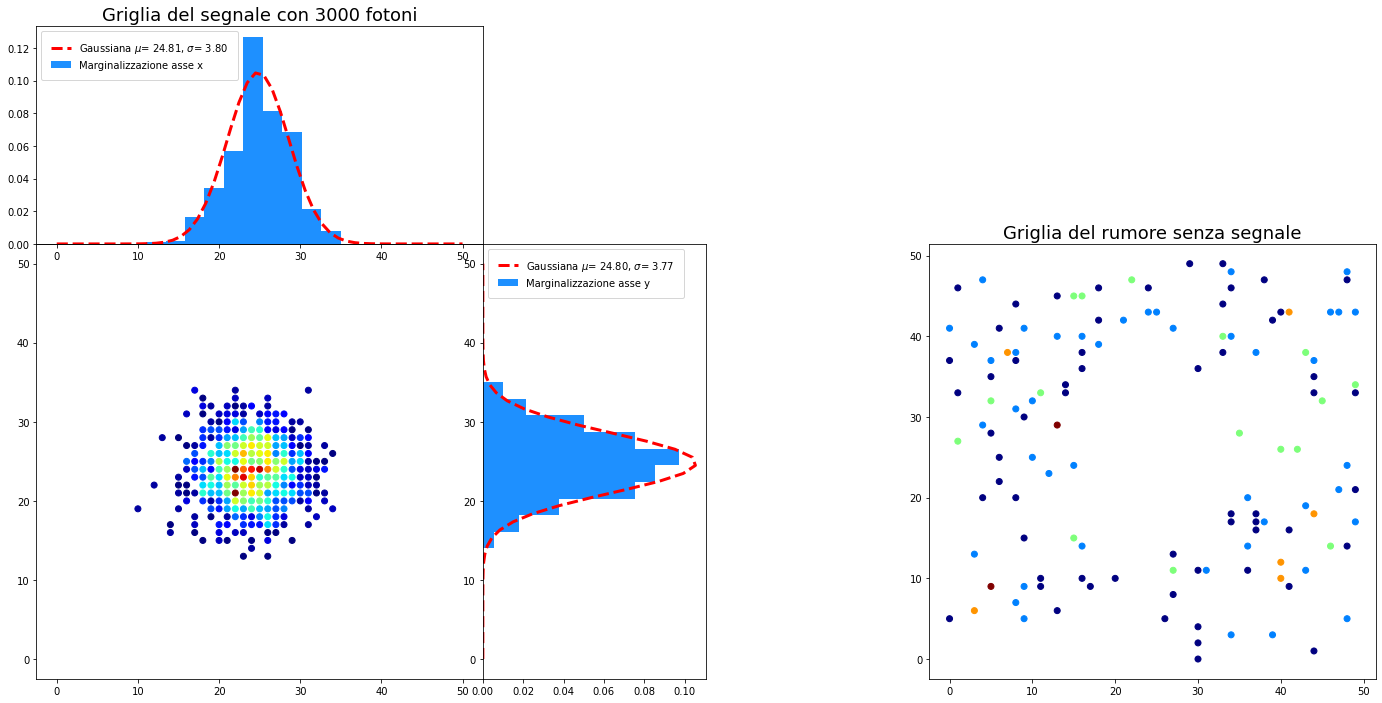

In [5]:
# Istogramma segnale

hist_x = np.apply_along_axis(sum,0,signal)
hist_y = np.apply_along_axis(sum,1,signal)
x = np.linspace(0,L,L)

fig = plt.figure(figsize=(28,12))
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

ax1 = plt.subplot2grid((3,7),(1,0),rowspan=2,colspan=2)
ax1.scatter(signal_plot[:,0],signal_plot[:,1],c=signal_plot[:,2],cmap='jet')

ax2 = plt.subplot2grid((3,7),(1,2),colspan=1,rowspan=2,sharey=ax1)
hist_y_fit = array_for_fit(hist_y)
mu, std = norm.fit(hist_y_fit)
ax2.hist(hist_y_fit, bins=10, density=True, color='dodgerblue', orientation='horizontal', label='Marginalizzazione asse y')
ax2.plot(np.exp(-0.5*((x-mu)/std)**2) /(std*np.sqrt(2*np.pi)), x, 'r--', linewidth=3, label='Gaussiana $\mu$= %.2lf, $\sigma$= %.2lf'%(mu, std))
ax2.legend( loc='upper left', borderpad=1)
 
ax3 = plt.subplot2grid((3,7),(0,0),colspan=2,rowspan=1,sharex=ax1)
hist_x_fit = array_for_fit(hist_x)
mu, std = norm.fit(hist_x_fit)
ax3.hist(hist_x_fit, bins=10, density=True, color='dodgerblue', label='Marginalizzazione asse x')
ax3.plot(x, np.exp(-0.5*((x-mu)/std)**2) /(std*np.sqrt(2*np.pi)), 'r--', linewidth=3, label='Gaussiana $\mu$= %.2lf, $\sigma$= %.2lf'%(mu, std))
ax3.legend( loc='upper left', borderpad=1)
plt.title('Griglia del segnale con %d fotoni'%n_samples, fontsize = 18)

# Istogramma rumore 

hist_x = np.apply_along_axis(sum,0,background)
hist_y = np.apply_along_axis(sum,1,background)
x = np.linspace(0,L,L)

ax4 = plt.subplot2grid((3,7),(1,4),rowspan=2,colspan=2)
ax4.scatter(background_plot[:,0],background_plot[:,1],c=background_plot[:,2],cmap='jet')
plt.title('Griglia del rumore senza segnale', fontsize = 18)

#ax5 = plt.subplot2grid((3,7),(1,6),colspan=1,rowspan=2,sharey=ax4)
#hist_y_fit = array_for_fit(hist_y)
#ax5.hist(hist_y_fit, orientation='horizontal', bins=10, density=True, color='dodgerblue', label='Marginalizzazione asse y')
#ax5.legend( loc='upper left', borderpad=1)

#ax6 = plt.subplot2grid((3,7),(0,4),colspan=2,rowspan=1,sharex=ax4)
#hist_x_fit = array_for_fit(hist_x)
#ax6.hist(hist_x_fit, bins=10, color='dodgerblue', density=True, label='Marginalizzazione asse x')
#ax6.legend( loc='upper left', borderpad=1)

plt.show()


**DBSCAN**

punti segnale dbscan=264   punti segnale vero=251   intersezione=244  purity=0.918033


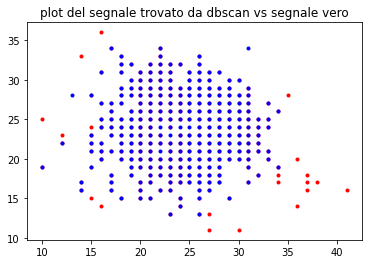

punti segnale dbscan=252   punti segnale vero=251   intersezione=237  purity=0.936709


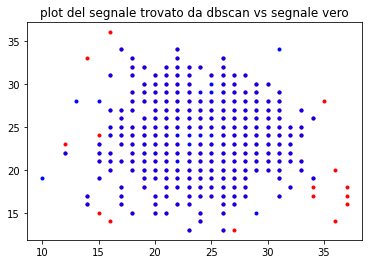

punti segnale dbscan=136   punti segnale vero=251   intersezione=133  purity=0.977444


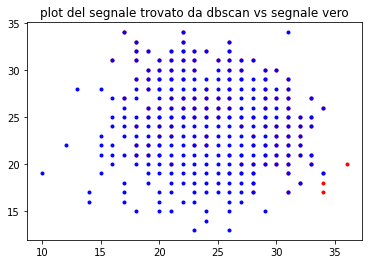

punti segnale dbscan=20   punti segnale vero=251   intersezione=20  purity=1.000000


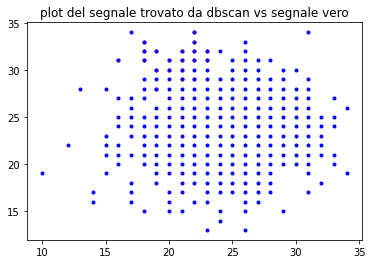

punti segnale dbscan=273   punti segnale vero=251   intersezione=247  purity=0.894737


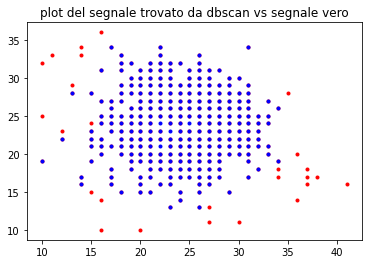

punti segnale dbscan=264   punti segnale vero=251   intersezione=245  purity=0.922449


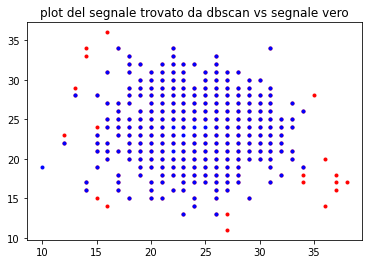

punti segnale dbscan=241   punti segnale vero=251   intersezione=233  purity=0.965665


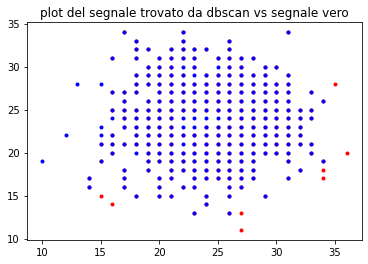

punti segnale dbscan=97   punti segnale vero=251   intersezione=97  purity=1.000000


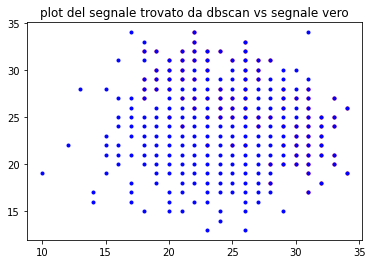

punti segnale dbscan=277   punti segnale vero=251   intersezione=246  purity=0.873984


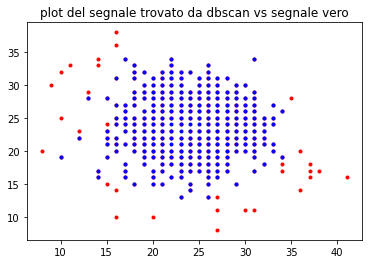

punti segnale dbscan=267   punti segnale vero=251   intersezione=246  purity=0.914634


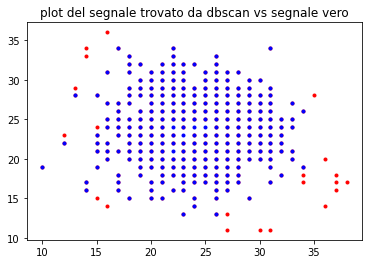

punti segnale dbscan=259   punti segnale vero=251   intersezione=243  purity=0.934156


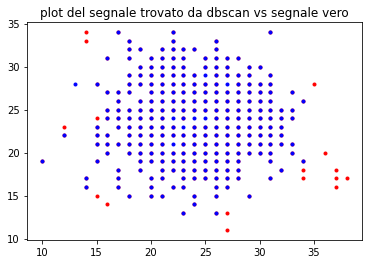

punti segnale dbscan=149   punti segnale vero=251   intersezione=148  purity=0.993243


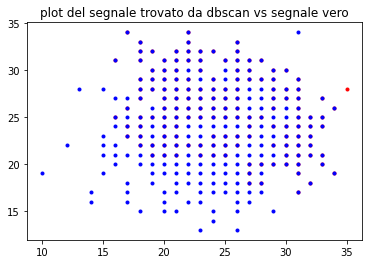

punti segnale dbscan=289   punti segnale vero=251   intersezione=248  purity=0.834677


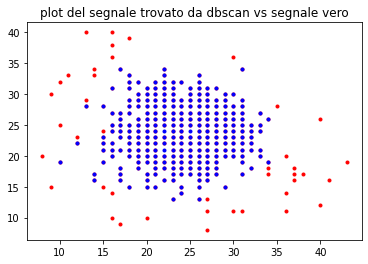

punti segnale dbscan=276   punti segnale vero=251   intersezione=246  purity=0.878049


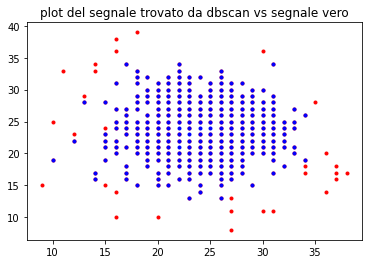

punti segnale dbscan=270   punti segnale vero=251   intersezione=246  purity=0.902439


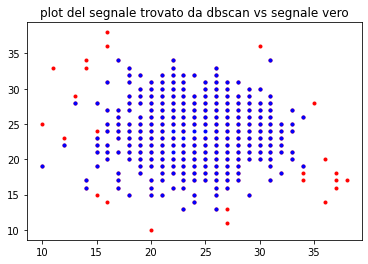

punti segnale dbscan=253   punti segnale vero=251   intersezione=239  purity=0.941423


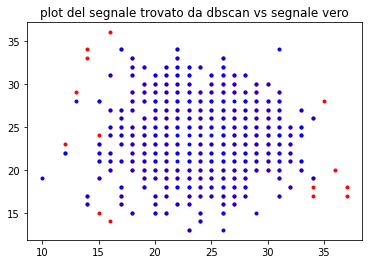

punti segnale dbscan=157   punti segnale vero=251   intersezione=154  purity=0.980519


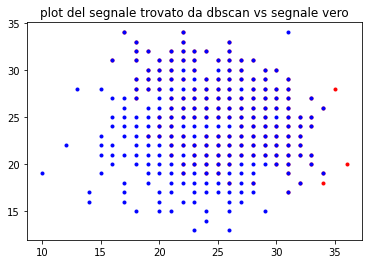

punti segnale dbscan=39   punti segnale vero=251   intersezione=39  purity=1.000000


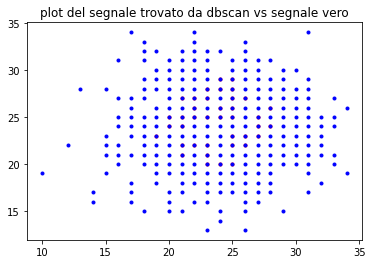

punti segnale dbscan=304   punti segnale vero=251   intersezione=249  purity=0.779116


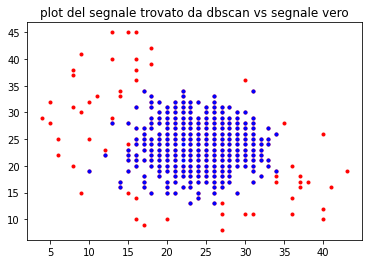

punti segnale dbscan=279   punti segnale vero=251   intersezione=246  purity=0.865854


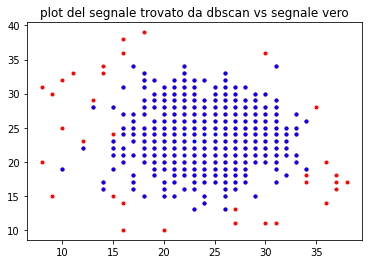

punti segnale dbscan=270   punti segnale vero=251   intersezione=246  purity=0.902439


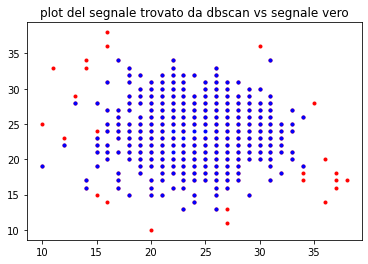

punti segnale dbscan=260   punti segnale vero=251   intersezione=243  purity=0.930041


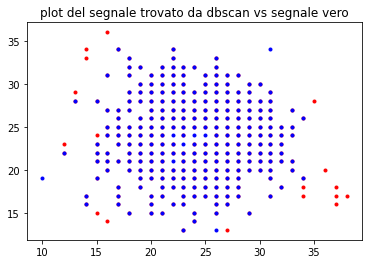

punti segnale dbscan=211   punti segnale vero=251   intersezione=206  purity=0.975728


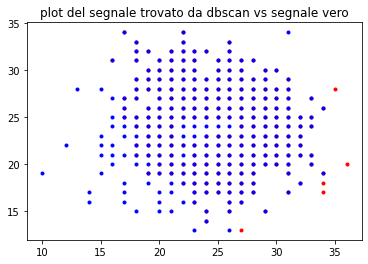

punti segnale dbscan=69   punti segnale vero=251   intersezione=69  purity=1.000000


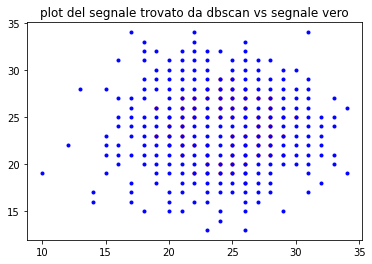

punti segnale dbscan=321   punti segnale vero=251   intersezione=249  purity=0.710843


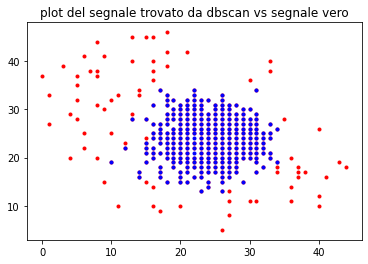

punti segnale dbscan=290   punti segnale vero=251   intersezione=247  purity=0.825911


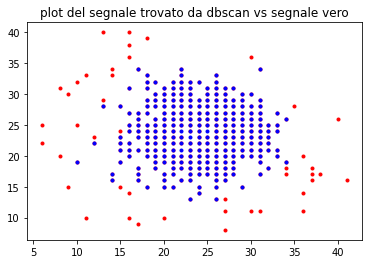

punti segnale dbscan=279   punti segnale vero=251   intersezione=246  purity=0.865854


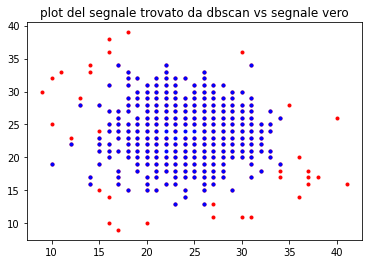

punti segnale dbscan=271   punti segnale vero=251   intersezione=246  purity=0.898374


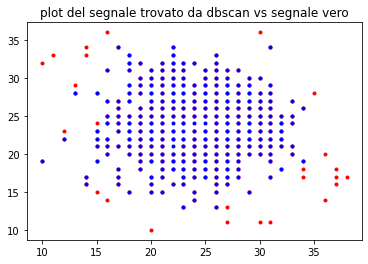

punti segnale dbscan=236   punti segnale vero=251   intersezione=228  purity=0.964912


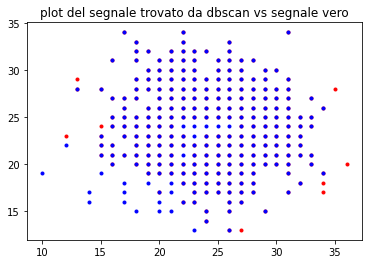

In [0]:
info_cluster=0                #if !=0 print numero di cluster individuati, numero di punti rumore, parametri l'efficienza
plot_cluster=0                #if !=0 plot dei cluster individuati
print_eff=0                   #if !=0 print efficienza per ogni run
plot_purity=1

eps_range = []
min_samples_range = []
efficiency_best = []

min_eps = 4
max_eps = 8
step_eps = 0.5

for eps in np.arange(min_eps, max_eps, step_eps):

    min_min_samples = 2*eps
    max_min_samples = 10*eps
    step_min_samples = eps

    found=[]

    for min_samples in np.arange(min_min_samples, max_min_samples, step_min_samples):

        # CLUSTERING

        eps_range.append(eps)
        min_samples_range.append(min_samples)

        db = DBSCAN(eps, min_samples).fit(points)
        core_samples_mask = np.zeros_like(db.labels_,dtype=bool)       # Inizializza un array booleano, della stessa forma di labels_
        core_samples_mask[db.core_sample_indices_] = True              # Considera tutti i core trovati da dbscan
        labels = db.labels_

        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)    # Conta i cluster, togliendo il  rumore (k=-1)
        n_noise_ = list(labels).count(-1)                              # Numero di punti di rumore

        if info_cluster != 0:

          print('Estimated number of clusters: %d' % n_clusters_)
          print('Estimated number of noise points: %d' % n_noise_)

        mean_dist = []
        members = []

        # Plot dei cluster individuati

        unique_labels = set(labels)
        colors = [plt.cm.Spectral(each)
        for each in np.linspace(0, 1, len(unique_labels))]             # Sceglie la palette di   colori senza il nero

        efficiency = 0
        weight_sum = 0

        clusters_points = (labels==-1)  #seleziono tutti i punti clusterizzati tranne il rumore
       
        
        punti=points[~clusters_points] #punti clusterizzati da dbscan come segnale e basta
       

        for k, col in zip(unique_labels, colors):                      # Per ogni cluster, associo un colore
        
            class_member_mask = (labels == k)                          # Seleziona tutti i punti del cluster k

            xy_core = points[class_member_mask & core_samples_mask]    # Solo se è nel cluster E è un core point
            xy_border = points[class_member_mask & ~core_samples_mask] # Solo se è nel cluster E non è core  ==  è un edge point del cluster
            
            # Efficienza della clusterizzazione

            phot = 0
            x = 0
            y = 0

            if k == -1:

              col = [0, 0, 0, 1]                          # Nero per il rumore

            else:

              for i in np.arange(0,len(xy_core),1):       # Somme sui pixel contenuti nel cluster k, pesate con il numero di fotoni
                
                x += xy_core[i][0] * xy_core[i][2]
                y += xy_core[i][1] * xy_core[i][2]
                phot += xy_core[i][2]

              for i in np.arange(0,len(xy_border),1):
                
                x += xy_border[i][0] * xy_border[i][2]
                y += xy_border[i][1] * xy_border[i][2]
                phot += xy_border[i][2]

              x /= phot
              y /= phot

              dist = np.sqrt((x-centers[0][0])**2+(y-centers[0][1])**2)
              eff_partial = ((tot_signal - abs(tot_signal-len(xy_core)-len(xy_border)) )/tot_signal)*1/dist

              if eff_partial < 0:
                
                efficiency += 0

              else:

                efficiency += eff_partial
              
              weight_sum += 1/dist

              

            if plot_cluster != 0:

              plt.plot(xy_core[:, 0], xy_core[:, 1], '.',markerfacecolor=tuple(col),
                    markeredgecolor=tuple(col), markersize=5)

              plt.plot(xy_border[:, 0], xy_border[:, 1], '.',markerfacecolor=tuple(col),
                    markeredgecolor=tuple(col), markersize=5)

        #purezza

        if len(punti) > 0: 

          len_sig=len(signal_plot)
          len_punti=len(punti)

          count_p=0
          for i in range (len_sig):
            for j in range (len_punti):
              if punti[j,0]==signal_plot[i,0] and punti[j,1]==signal_plot[i,1] and punti[j,2]==signal_plot[i,2]:
                count_p+=1
        
            
          purity=1-(len(punti)-count_p)/count_p
          #se dbscan non 'inventa' altri punti di segnale (purezza=1), ma ne trova di meno rispetto al segnale vero, cosa si fa? 

          if plot_purity!=0:

            print('punti segnale dbscan=%d   punti segnale vero=%d   intersezione=%d  purity=%f' %(len_punti,len_sig,count_p,purity)) 
            plt.title('plot del segnale trovato da dbscan vs segnale vero')
            plt.plot(punti[:,0],punti[:,1],'r.')
            plt.plot(signal_plot[:,0],signal_plot[:,1],'b.')
            plt.show()

           
        if n_clusters_ != 0:

          efficiency /= weight_sum
          
          efficiency_best.append(efficiency)

        else:
          
          efficiency_best.append(0)
          
        if print_eff != 0:
          print('Eps: %.2f Min_samples: %.2f Efficiency: %f Purity: %f Efficiency*Purity: %f' %(eps,min_samples,efficiency,purity,efficiency*purity))

        if plot_cluster != 0:

          plt.title('Eps=%.1lf, min_samples=%d, estimated number of clusters: %d' % (eps,min_samples,n_clusters_))
          fig = matplotlib.pyplot.gcf()
          fig.set_size_inches(6,6)
          plt.show()

#print('Threshold: %.2f Eps: %.2f Min_samples: %.2f Best efficiency: %f Best Purity: %f Overall efficiency: %f' %(th,eps_range[index],min_samples_range[index],efficiency_best[index],purity_best[index],max_efficiency))


